# 0. Install and Import Dependencies

In [2]:
%pip install opencv-python matplotlib imageio gdown tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [6]:
import gdown

In [7]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [8]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [13]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [14]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [15]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [16]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [17]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [18]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

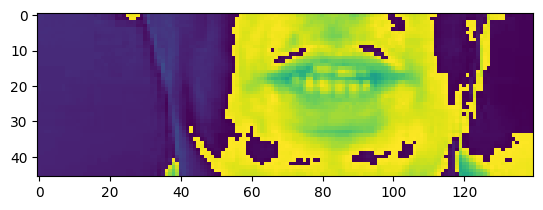

In [19]:
plt.imshow(frames[40])

In [20]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [21]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [22]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [23]:
from matplotlib import pyplot as plt

In [24]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [25]:
len(test)

50

In [26]:
frames, alignments = data.as_numpy_iterator().next()

In [27]:
len(frames)

2

In [28]:
sample = data.as_numpy_iterator()

In [29]:
val = sample.next();val[0]

array([[[[[ 1.2975911 ],
          [ 1.2975911 ],
          [ 1.2975911 ],
          ...,
          [ 9.948198  ],
          [ 9.987519  ],
          [ 9.987519  ]],

         [[ 1.2975911 ],
          [ 1.2975911 ],
          [ 1.2975911 ],
          ...,
          [ 9.948198  ],
          [ 9.987519  ],
          [ 9.987519  ]],

         [[ 1.2189492 ],
          [ 1.2189492 ],
          [ 1.2189492 ],
          ...,
          [ 9.987519  ],
          [ 9.987519  ],
          [ 9.987519  ]],

         ...,

         [[ 0.8257398 ],
          [ 0.8257398 ],
          [ 0.8257398 ],
          ...,
          [ 9.672952  ],
          [ 9.633631  ],
          [ 9.633631  ]],

         [[ 0.8257398 ],
          [ 0.8257398 ],
          [ 0.8257398 ],
          ...,
          [ 9.712273  ],
          [ 9.672952  ],
          [ 9.672952  ]],

         [[ 0.8257398 ],
          [ 0.8257398 ],
          [ 0.8257398 ],
          ...,
          [ 9.712273  ],
          [ 9.672952  ],
          

In [30]:
# imageio.mimsave('./animation.gif', val[0][0], fps=10)

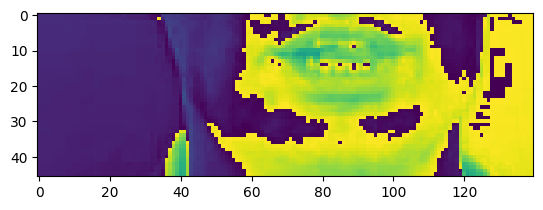

In [31]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][25])

In [32]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place white by k zero now'>

# 3. Design the Deep Neural Network

In [33]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [34]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [35]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
5*17*75

6375

In [38]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [39]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'!uuugggggggggggggggggggggggggggggggggggggddddddddddddddddddgggggggggggggggg'>

In [40]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'!uuugggggggggggggggggggggggggggggggggggggddddddddddddddddddgggggggggggggggg'>

In [41]:
model.input_shape

(None, 75, 46, 140, 1)

In [42]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [43]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [44]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [45]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [46]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [56]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [50]:
schedule_callback = LearningRateScheduler(scheduler)

In [51]:
example_callback = ProduceExample(test)

In [57]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/time_distributed_1/Reshape_10 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1043, in launch_instance

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 725, in start

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Program Files\Python311\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Program Files\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Program Files\Python311\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 502, in process_one

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 540, in run_cell

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_16104\3536403359.py", line 1, in <module>

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\trainer.py", line 314, in fit

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\trainer.py", line 117, in one_step_on_iterator

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\trainer.py", line 104, in one_step_on_data

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\trainer.py", line 51, in train_step

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\models\sequential.py", line 209, in call

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py", line 202, in call

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\ops\function.py", line 155, in _run_through_graph

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py", line 592, in call

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\time_distributed.py", line 108, in call

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\time_distributed.py", line 108, in <listcomp>

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\time_distributed.py", line 102, in step_function

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py", line 54, in call

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\ops\numpy.py", line 4415, in reshape

  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\numpy.py", line 1778, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1/time_distributed_1/Reshape_10}}]] [Op:__inference_one_step_on_iterator_31151]

# 5. Make a Prediction 

In [ ]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

In [59]:
model.load_weights('models/checkpoint')

FileNotFoundError: [Errno 2] No such file or directory: './models/checkpoint.keras'

In [61]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [64]:
yhat = model.predict(sample[0])

TypeError: 'NumpyIterator' object is not subscriptable

In [65]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


TypeError: 'NumpyIterator' object is not subscriptable

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]